In [7]:
# set cwd and solver
import os
import cobra
cobra.Configuration().solver = "gurobi"
os.chdir('C:/Users/prins/GitHub/Human1_RPE-PR') 

In [8]:
# load combined RPE_PR models
from pathlib import Path
from cobra.io import read_sbml_model

mod_RPE_PR = read_sbml_model(Path().cwd() / "models" / "mod_RPE_PR.xml")
mod_RPE_PR.id = 'RPE_PR_old'
mod_RPE_PR.name = 'RPE_PR_old'
mod_Human1_Human1 = read_sbml_model(Path().cwd() / "models" /  "mod_Human1_Human1.xml")
mod_Human1_Human1.id = 'RPE_PR_control_old'
mod_Human1_Human1.name = 'RPE_PR_control_old'
mod = read_sbml_model(Path().cwd() / 'models/Human-GEM.xml')
mod.id = 'Human1_old'
mod.name = 'Human1_old'  

In [9]:
# load all models in \cs_mods\July2023 folder by cycling through names
from cobra.io import read_sbml_model    
import glob 
import os   

# set folder without changing cwd
folder = Path().cwd() / 'cs_mods/July2023'
os.chdir(folder) # set cwd
model_list = []
for file in folder.glob('*.xml'):
    model = read_sbml_model(file)
    model.id = file.stem # remove .xml 
    model.name = file.stem
    model_list.append(model)

No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized
No objective coefficients in model. Unclear what should be optimized


In [10]:
model_list

[<Model Human-GEM_28062023 at 0x12db9abfbb0>,
 <Model mod_RPE_PRcone_Liang at 0x12dcc788ca0>,
 <Model mod_RPE_PRcone_Liang_singlePR at 0x12db9bc2e30>,
 <Model mod_RPE_PRcone_Liang_singleRPE at 0x12d25e126b0>,
 <Model mod_RPE_PRcone_Lukowski at 0x12dd153ba60>,
 <Model mod_RPE_PRcone_Lukowski_singlePR at 0x12d24c2a830>,
 <Model mod_RPE_PRcone_Lukowski_singleRPE at 0x12de03155a0>,
 <Model mod_RPE_PRcontrol at 0x12de5c57430>,
 <Model mod_RPE_PRrod_Liang at 0x12dfa1d7580>,
 <Model mod_RPE_PRrod_Liang_singlePR at 0x12e0250fc40>,
 <Model mod_RPE_PRrod_Liang_singleRPE at 0x12e062ab7c0>,
 <Model mod_RPE_PRrod_Lukowski at 0x12e0a3cab30>,
 <Model mod_RPE_PRrod_Lukowski_singlePR at 0x12e0c01c5e0>,
 <Model mod_RPE_PRrod_Lukowski_singleRPE at 0x12e15d33220>]

In [ ]:

model_list = []
for file in glob.glob("*.xml"):  
    model = read_sbml_model(file)
    model.id = file[:-4] # remove .xml 
    model.name = file[:-4] # remove .xml
    model_list.append(model)
os.chdir('C:/Users/prins/GitHub/Human1_RPE-PR') # reset cwd

In [6]:
# add old models to model_list
model_list = model_list + [mod,mod_RPE_PR]

# check out model_list
model_list

NameError: name 'model_list' is not defined

In [5]:
# for all models in the list set objective function (ATP hydrolysis, in PR for combined models)

for m in model_list:
    if 'MAR03964_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_PR'
    elif 'MAR03964_RPE' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_RPE'
    elif 'MAR03964' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964'
    else:
        print('no ATP hydrolysis reaction (MAR03964) in model: ' + m.id)

In [6]:
# list combined and single models
combined_models = [m for m in model_list if 'single' not in m.id]
single_models = [m for m in model_list if 'single' in m.id]

# close PR exchange in combined models and open RPE exchange (efflux)
for m in combined_models:
    for r in [r for r in m.reactions if len(r.products) == 0 ]:           # close all exchange reactions
        r.bounds=(0,0)
    for r in [r for r in m.reactions if len(r.products) == 0 if '_RPE' in r.id]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000) 

# only allow efflux exchange in single models
for m in single_models:
    for r in [r for r in m.reactions if len(r.products) == 0 ]:           # close all exchange reactions
        r.bounds=(0,1000)

# for Human1 models, open efflux
for m in [m for m in model_list if 'Human' in m.id]:
    for r in [r for r in m.reactions if len(r.products) == 0]:           # open efflux for RPE exchange reactions
        r.bounds=(0,1000)

In [193]:
# dark new estimates
# MAR09048 = oxygen exchange
# MAR09034 = glucose exchange
# MAR09135 = lactate exchange

def set_exchange_bounds(model, ex_dict): 
    """
    set bounds for exchange reactions in model based on dict

    Parameters
    ----------
    model : cobra.Model
        model to set bounds for
    ex_dict : dict
        dictionary with exchange reaction ids as keys and bounds as values

    Returns
    -------
    model : cobra.Model
        model with updated bounds

    """

    for ex in ex_dict.keys():
        if ex + '_RPE' in [r.id for r in model.reactions]:
            model.reactions.get_by_id(ex + '_RPE').bounds = ex_dict[ex] # set bounds for RPE exchange
        elif ex + '_PR' in [r.id for r in model.reactions]:
            model.reactions.get_by_id(ex + '_PR').bounds = ex_dict[ex] # if no RPE exchange, set bounds for PR exchange
        elif ex + '_eRPE_PR' in [r.id for r in model.reactions]:
            model.reactions.get_by_id(ex + '_eRPE_PR').bounds = ex_dict[ex] # if no RPE or PR exchange, set bounds for eRPE_PR exchange
        elif ex in [r.id for r in model.reactions]:
            model.reactions.get_by_id(ex).bounds = ex_dict[ex] # if no RPE, PR, or eRPE_PR exchange, set bounds for exchange (generic)
        else:  
            print('no exchange reaction for ' + ex + ' in model: ' + model.id) # if no exchange reaction, print message
    return model 


ex_bounds = {'MAR09048':(-3.51,1000),'MAR09034':(-4.18,1000),'MAR09135':(7.25,1000)}

for m in model_list:
    set_exchange_bounds(m, ex_bounds)

import pandas as pd
results_dict = {}
for m in model_list:
    m.optimize()
    results_dict[m.id] = m.objective.value
df1 = pd.DataFrame(results_dict, index = ['max ATP hydrolysis (pmol/s/mm^2)']).T
df1


,max ATP hydrolysis (pmol/s/mm^2)
Human-GEM_28062023,24.7325
mod_RPE_PRcone_Liang,23.9000
mod_RPE_PRcone_Liang_singlePR,11.1350
mod_RPE_PRcone_Liang_singleRPE,23.9000
mod_RPE_PRcone_Lukowski,24.7325
mod_RPE_PRcone_Lukowski_singlePR,22.2350
mod_RPE_PRcone_Lukowski_singleRPE,23.9000
mod_RPE_PRcontrol,24.7325
mod_RPE_PRrod_Liang,23.9000
mod_RPE_PRrod_Liang_singlePR,13.9100


In [2]:
# single if 'single', 'Human-GEM_28062023', or 'Human1_old' in df1.index else 'combined'
index1= ['single' if 'single' in x \
        or 'Human-GEM_28062023' in x \
        or 'Human1_old' in x \
        else 'combined' for x in list(df1.index)]

# 'Lukowski'if in df1.index, 'Liang' if in df1.index, Human1 if in df1.index else ''
index2 = ['Lukowski' if 'Lukowski' in x \
        else 'Liang' if 'Liang' in x \
        else 'none' if 'Human' or 'control' in x \
        else 'Liang' for x in list(df1.index)]

# 'cone'if ends with cone in df1.index, 'rod' if ends with PR and contains rod in df1.index, RPE if ends with RPE df1.index, Human1 if Human1 in df1.index, else 'RPE-PR
index3 = ['cone' if x.endswith('PR') and 'cone' in x \
        else 'rod' if x.endswith('PR') and 'rod' in x \
        else 'RPE' if x.endswith('RPE') \
        else 'Human1' if 'Human1_old' in x \
        else 'Human1' if 'Human-GEM_28062023' in x \
        else 'Human1-Human1' if 'control'in x \
        else 'Human1-Human1' if 'RPE_PR_old'in x
        else 'RPE-PR rod' if 'RPE_PRrod' in x\
        else 'RPE-PR cone' if 'RPE_PRcone' in x\
        else 'RPE-PR rod' for x in list(df1.index)]


x_ticks = [1 if 'Human' in x \
        else 2 if x is 'RPE' \
        else 3 if 'cone' in x \
        else 4 if 'rod' in x \
        else '' for x in index3]

index = pd.DataFrame([x_ticks,index1, index2, index3]).T

# add index as new index to df1
df2 = pd.concat([index,df1.reset_index()], axis=1)
df2.columns = ['xticks','type','PR_data','cell','model_name','max ATP hydrolysis (pmol/s/mm^2)']
df2_combined = df2[df2['type'] == 'combined']
df2_single = df2[df2['type'] == 'single']
df2




<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:27: SyntaxWarning: "is" with a literal. Did you mean "=="?


NameError: name 'df1' is not defined

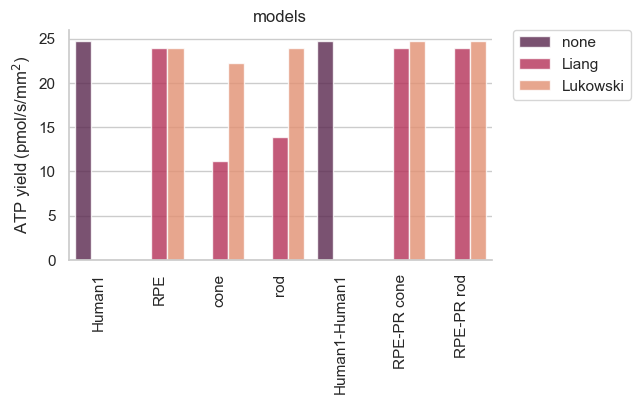

In [9]:
# plot results with seaborn catplot

# FIG
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")


# change order of bars in plot to Human1, Human1 (old), RPE, cone, rod make sure to have seperate bars for each datapoint
g_all = sns.catplot(
    data=df2, kind="bar",
    x="cell", y="max ATP hydrolysis (pmol/s/mm^2)", hue="PR_data", 
    order = ['Human1','RPE','cone','rod','Human1-Human1','RPE-PR cone','RPE-PR rod'],
     palette="rocket", alpha=.8, height=4,
)
g_all.despine(left=False)
g_all.set_axis_labels("","ATP yield (pmol/s/mm$^{2}$)")
g_all.legend.set_title("expression data")
# rotate x-axis labels
plt.xticks(rotation=90)
plt.tight_layout()
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plot title
plt.title('models')

#remove one of the two legends
g_all._legend.remove()
g_all.legend.set_title("expression data")

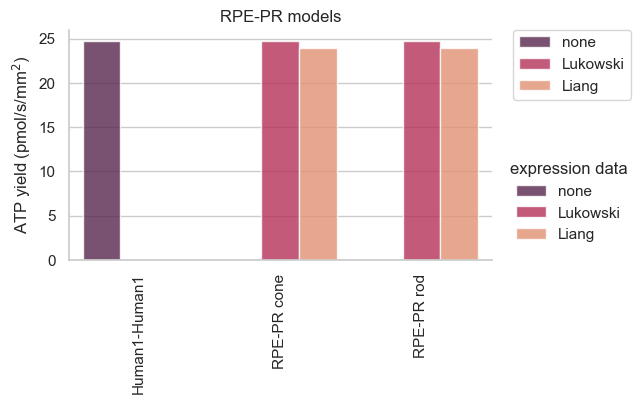

In [10]:
# plot results with seaborn catplot

# FIG
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# select only combined models
df2_combined = df2[df2['type'] == 'combined']

# change order of bars in plot to Human1, Human1 (old), RPE, cone, rod make sure to have seperate bars for each datapoint
g_combined = sns.catplot(
    data=df2_combined, kind="bar",
    x="cell", y="max ATP hydrolysis (pmol/s/mm^2)", hue="PR_data", hue_order=['none','Lukowski','Liang'],
    order = ['Human1-Human1','RPE-PR cone','RPE-PR rod'],
     palette="rocket", alpha=.8, height=4,
)
g_combined.despine(left=False)
g_combined.set_axis_labels("","ATP yield (pmol/s/mm$^{2}$)")

# rotate x-axis labels
plt.xticks(rotation=90)
plt.tight_layout()
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plot title
plt.title('RPE-PR models')

#remove one of the two legends
g_combined.legend.set_title("expression data")
    

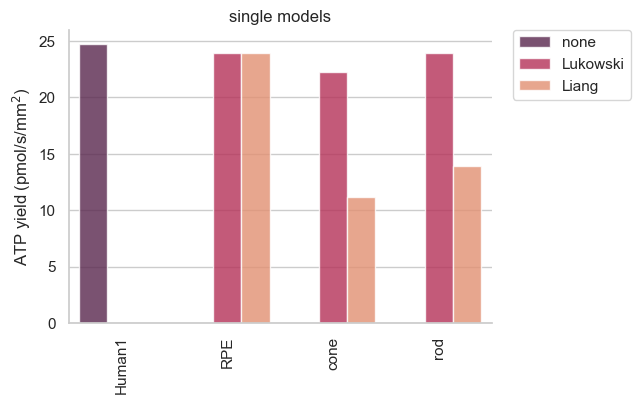

In [11]:
# plot results with seaborn catplot

# FIG
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# select only combined models
df2_single = df2[df2['type'] == 'single']

# change order of bars in plot to Human1, Human1 (old), RPE, cone, rod make sure to have seperate bars for each datapoint
g_single = sns.catplot(
    data=df2_single, kind="bar",
    x="cell", y="max ATP hydrolysis (pmol/s/mm^2)", hue="PR_data", hue_order=['none','Lukowski','Liang'],
    order = ['Human1','RPE','cone','rod'],
     palette="rocket", alpha=.8, height=4,
)
g_single.despine(left=False)
g_single.set_axis_labels("","ATP yield (pmol/s/mm$^{2}$)")

# rotate x-axis labels
plt.xticks(rotation=90)
plt.tight_layout()
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plot title
plt.title('single models')

#remove one of the two legends
g_single._legend.remove()
g_single.legend.set_title("expression data")
    

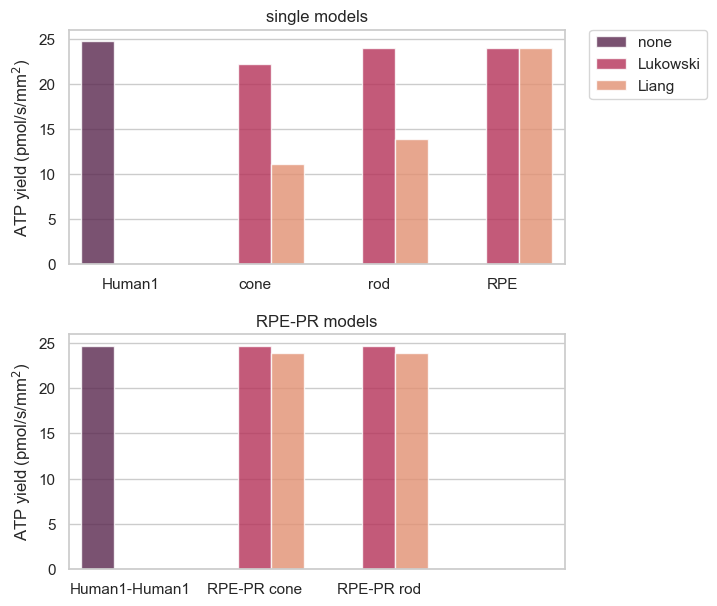

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

# set up figure with two subplots
fig, axs = plt.subplots(nrows=2)    
# increase height of figure
fig.set_figheight(7)

# plot results with seaborn barplot (SINGLE MODELS)
sns.barplot(x='cell', 
            y='max ATP hydrolysis (pmol/s/mm^2)',
             data=df2_single, 
             ax=axs[0], 
             hue='PR_data',
            hue_order=['none','Lukowski','Liang'], 
            order = ['Human1','cone','rod','RPE'], 
            palette="rocket", alpha=.8, )

axs[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# plot results with seaborn barplot (COMBINED MODELS)
sns.barplot(x='cell', 
            y='max ATP hydrolysis (pmol/s/mm^2)', 
            data=df2_combined, ax=axs[1], 
            hue="PR_data", 
            hue_order=['none','Lukowski','Liang'], 
            order = ['Human1-Human1','RPE-PR cone','RPE-PR rod'],
            palette="rocket", alpha=.8, )

# make bars same width for both subplots
axs[1].set_xlim(axs[0].get_xlim())

# move legend outside of plot
axs[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# add axis titles
axs[0].set_title('single models')
axs[1].set_title('RPE-PR models')
# add y-axis label
axs[0].set_ylabel('ATP yield (pmol/s/mm$^{2}$)')
axs[1].set_ylabel('ATP yield (pmol/s/mm$^{2}$)')
# remove x-axis label
axs[0].set_xlabel('')
axs[1].set_xlabel('')
#increase space between subplots
plt.subplots_adjust(hspace=0.3)
# remove one of the two legends using  get_legend().remove()
axs[1].get_legend().remove()


In [174]:
# function

def sample(models, n_samples):
    """
    
    Sample the flux space of a model.

    Parameters
    ----------
    models : list
        A list of cobra.Model objects.
    n_samples : int
        The number of samples to generate.

    returns
    -------

    df_sampling_results : dataframe
        A dataframe with the results of the sampling.
        
    """

    # sampling of the flux space
    from cobra.sampling import sample

    # empty dict to store results
    results_dict = {}
    for m in models:
        # print name of model being samples
        print(m.id)
        # print name objective function
        print(m.objective)
        # sample model
        s = sample(m, n_samples)
        # record results in dict
        results_dict[m.id] = s.T

    # convert dict to dataframe
    df_sampling_results = pd.concat(results_dict, axis=1)
    return df_sampling_results

def fva(models):
    """
    RPE_PR data
    Perform flux variability analysis on a list of models.

    Parameters
    ----------
    models : list
        A list of cobra.Model objects.

    returns
    -------
    df_fva_results : dataframe
        A dataframe with the results of the flux variability analysis.

    """

    # flux variability analysis
    from cobra.flux_analysis import flux_variability_analysis

    # empty dict to store results
    results_dict = {}
    for m in models:
        # print name of model being samples
        print(m.id)
        # print name objective function
        print(m.objective)
        # do loopless flux variability analysis on m
        fva_loopless = flux_variability_analysis(m, fraction_of_optimum=0.9, loopless=True)
        fva = flux_variability_analysis(m, fraction_of_optimum=0.9, loopless=False)
        # add '_loopless' to column names
        fva_loopless.columns = [str(col) + '_loopless' for col in fva_loopless.columns]
        # merge fva and fva_loopless horizontally, match index
        fva_combined = fva.merge(fva_loopless, left_index=True, right_index=True)

        # record results in dict
        results_dict[m.id] = fva_combined

        # convert dict to dataframe
        df_fva_results = pd.concat(results_dict, axis=1)
    return df_fva_results

def fba(models):
    """

    Perform flux balance analysis on a list of models.

    Parameters
    ----------
    models : list
        A list of cobra.Model objects.

    returns
    -------
    fba : dataframe
        A dataframe with the results of the flux balance analysis.
    
    """
    from cobra.flux_analysis.loopless import add_loopless, loopless_solution
    
    # empty dict to store results
    results_dict = {}
    
    for m in models:
        # FBA
        fba = m.optimize()
        # get fluxes and rename column
        fba = pd.DataFrame(fba.to_frame()['fluxes']).rename(columns={'fluxes':'fba'})

        # FBA
        fba = m.optimize()
        # get fluxes and rename column
        fba = pd.DataFrame(fba.to_frame()['fluxes']).rename(columns={'fluxes':'fba'})

        # FBA loopless
        fba_loopless = loopless_solution(m)
        fba_loopless = pd.DataFrame(fba_loopless.fluxes)
        # rename column
        fba_loopless = fba_loopless.rename(columns={'fluxes':'fba_loopless'})
        fba_loopless

        # merge fba and loopless
        fba = fba.merge(fba_loopless, left_index=True, right_index=True)

        # record results in dict
        results_dict[m.id] = fba

    # convert dict to dataframe
    fba = pd.concat(results_dict, axis=1)
    return fba

In [235]:
# function

def sample_fva_fba(models, n_samples):
    """
    
    Sample the flux space of a model.

    Parameters
    ----------
    models : list
        A list of cobra.Model objects.
    n_samples : int
        The number of samples to generate.

    returns
    -------
    df_results : dataframe
        A dataframe with the results of the sampling, flux variability analysis and flux balance analysis.

    """

    from cobra.sampling import sample
    from cobra.flux_analysis import flux_variability_analysis
    from src.get_info import make_rxn_df

    results_dict = {}   # empty dict to store results
    for m in models:
        print(m.id)
        print(m.objective)
        # sampling of the flux space

        # sample model
        s = sample(m, n_samples).T # sample model

        # flux variability analysis
        fva_loopless = flux_variability_analysis(m, fraction_of_optimum=0.9, loopless=True) # loopless flux variability analysis on m
        fva = flux_variability_analysis(m, fraction_of_optimum=0.9, loopless=False) # flux variability analysis on m    
        fva_loopless.columns = [str(col) + '_loopless' for col in fva_loopless.columns] # add '_loopless' to column names
        fva = fva.merge(fva_loopless, left_index=True, right_index=True) # merge fva and fva_loopless horizontally, match index

        # FBA
        fba = m.optimize()
        fba = pd.DataFrame(fba.to_frame()['fluxes']).rename(columns={'fluxes':'fba'}) # get fluxes and rename column

        # FBA loopless
        fba_loopless = loopless_solution(m)
        fba_loopless = pd.DataFrame(fba_loopless.fluxes)
        fba_loopless = fba_loopless.rename(columns={'fluxes':'fba_loopless'}) # get fluxes and rename column
        fba = fba.merge(fba_loopless, left_index=True, right_index=True) # merge fba and loopless

        # make rxn df
        rxns=make_rxn_df(m)

        # merge rxns, s, fva, fba
        df_results = pd.concat([rxns,s,fva,fba], axis=1)
        results_dict[m.id] = df_results # record results in dict

    return results_dict

test_results = sample_fva_fba(single_models,2)
test_results

mod_RPE_PRcone_Liang_singlePR
Maximize
1.0*MAR03964_PR - 1.0*MAR03964_PR_reverse_e8402
Read LP format model from file C:\Users\prins\AppData\Local\Temp\tmpivgh3odz.lp
Reading time = 0.03 seconds
: 5053 rows, 12828 columns, 48114 nonzeros
mod_RPE_PRcone_Liang_singleRPE
Maximize
1.0*MAR03964_RPE - 1.0*MAR03964_RPE_reverse_dc7af
Read LP format model from file C:\Users\prins\AppData\Local\Temp\tmpfh4j9c87.lp
Reading time = 0.04 seconds
: 7186 rows, 19650 columns, 65514 nonzeros


KeyboardInterrupt: 

In [234]:
results['Human-GEM_28062023']

,cell,lb,ub,metanetx.reaction,reactome,sbo,bigg.reaction,tcdb,vmhreaction,kegg.reaction,...,met_IDs,GPR,0,1,minimum,maximum,minimum_loopless,maximum_loopless,fba,fba_loopless
MAR03905,None,0.0,1000.0,MNXR95725,,SBO:0000176,ALCD2x,,ALCD2if,R00754,...,MAM01796c + MAM02552c --> MAM01249c + MAM02039...,ENSG00000147576 or ENSG00000172955 or ENSG0000...,1.875809e-20,1.850070e-20,0.0,0.000000,0.0,0.000,0.0,0.0
MAR03907,None,0.0,1000.0,MNXR95726,,SBO:0000176,ALCD2y,,ALCD2yf,R00746,...,MAM01796c + MAM02554c --> MAM01249c + MAM02039...,ENSG00000117448,3.971515e-20,3.917021e-20,0.0,0.000000,0.0,0.000,0.0,0.0
MAR04097,None,0.0,1000.0,MNXR95413,,SBO:0000176,ACS,,ACS,R00235,...,MAM01252c + MAM01371c + MAM01597c --> MAM01261...,ENSG00000131069,3.538161e-07,3.882550e-07,0.0,1.648833,0.0,0.000,0.0,0.0
MAR04099,None,0.0,1000.0,MNXR95413,,SBO:0000176,ACSm,,ACSm,R00235,...,MAM01252m + MAM01371m + MAM01597m --> MAM01261...,ENSG00000111058 or ENSG00000154930,1.661491e-06,1.440616e-06,0.0,1.648833,0.0,0.000,0.0,0.0
MAR04108,None,0.0,1000.0,MNXR105304,,SBO:0000176,,,r0068,R00236,...,MAM01257c + MAM01597c --> MAM01261c + MAM01334...,ENSG00000131069,2.322541e+00,2.322376e+00,0.0,1.648833,0.0,0.000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAR20107,None,0.0,1000.0,MNXR100567,,SBO:0000176,"[HBZOPT10m, R_HBZOPT10m]",,,,...,MAM00995r + MAM01316r --> MAM00767r + MAM02759r,ENSG00000120942,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.000,0.0,0.0
MAR20108,None,0.0,1000.0,MNXR100567,,SBO:0000176,"[HBZOPT10m, R_HBZOPT10m]",,,,...,MAM00995g + MAM01316g --> MAM00767g + MAM02759g,ENSG00000120942,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.000,0.0,0.0
MAR20109,None,0.0,1000.0,MNXR100567,,SBO:0000176,"[HBZOPT10m, R_HBZOPT10m]",,,,...,MAM00995n + MAM01316n --> MAM00767n + MAM02759n,ENSG00000120942,0.000000e+00,0.000000e+00,0.0,0.000000,0.0,0.000,0.0,0.0
MAR20110,None,0.0,1000.0,MNXR102097,,SBO:0000176,,,,,...,MAM02039m + MAM02633m --> MAM01596m + MAM02819m,ENSG00000180185,2.083086e-06,2.186945e-06,0.0,3.852667,0.0,0.000,0.0,0.0


In [ ]:
def melt_results2long(results):
        # melt oxphos_glycolysis_fva_fba to long format using ids and column names as variables
        results_long = pd.melt(results.reset_index(),\
                id_vars=['index'], \
                value_vars=['minimum', 'maximum', 'minimum_loopless', 'maximum_loopless','fba', 'fba_loopless'])

        # add indexing columns
        index1= ['min' if 'min' in x \
                else 'max' if 'max' in x \
                else 'fba' if 'fba'in x \
                else '' for x in results_long['variable']]

                # add indexing columns
        index2= ['loopless' if 'loopless' in x \
                else '' for x in results_long['variable']]

        #add index1 and index2 to df
        results_long['type'] = index1
        results_long['loopless'] = index2

        return results_long 

results_long = melt_results2long(results)
results_long

KeyError: "The following 'value_vars' are not present in the DataFrame: ['maximum_loopless', 'minimum_loopless']"

In [ ]:
# do loopless flux variability analysis on single_models[0]
from cobra.flux_analysis import flux_variability_analysis
fva_loopless = flux_variability_analysis(single_models[0], fraction_of_optimum=0.9, loopless=True)
fva = flux_variability_analysis(single_models[0], fraction_of_optimum=0.9, loopless=False)
# add '_loopless' to column names
fva_loopless.columns = [str(col) + '_loopless' for col in fva_loopless.columns]
# merge fva and fva_loopless horizontally, match index
fva_combined = fva.merge(fva_loopless, left_index=True, right_index=True)
fva_combined

,minimum,maximum,minimum_loopless,maximum_loopless
MAR03989_eRPE_PR,0.0000,0.0000,0.0000,0.000
MAR04303_eRPE_PR,0.0000,0.0000,0.0000,0.000
MAR04416_eRPE_PR,0.0000,0.0000,0.0000,0.000
MAR04081_eRPE_PR,0.0000,0.0000,0.0000,0.000
MAR04086_eRPE_PR,0.0000,0.0000,0.0000,0.000
...,...,...,...,...
MAR20044_PR,0.0000,1000.0000,0.0000,0.000
MAR20070_PR,0.0000,1.1135,0.0000,0.000
MAR20089_PR,0.0000,0.0000,0.0000,0.000
MAR20110_PR,0.0000,0.0000,0.0000,0.000


In [ ]:
# add fva results to df_results_rxns
df_results_rxns_fva = df_results_rxns.merge(fva_combined, left_index=True, right_index=True)
df_results_rxns_fva

,cell,lb,ub,metanetx.reaction,reactome,sbo,bigg.reaction,tcdb,vmhreaction,kegg.reaction,...,4,5,6,7,8,9,minimum,maximum,minimum_loopless,maximum_loopless
MAR03989_eRPE_PR,PR,0.0,1000.0,MNXR101350,,SBO:0000176,MALTe,,MALTe,R00028,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0000,0.0000,0.000
MAR04303_eRPE_PR,PR,0.0,1000.0,MNXR104638,,SBO:0000176,SUCRe,,SUCRe,R00801,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0000,0.0000,0.000
MAR04416_eRPE_PR,PR,0.0,1000.0,MNXR100115,,SBO:0000176,,,r0627,R01104,...,1.397053e-17,1.351735e-17,-2.175101e-17,-2.174372e-17,-2.166645e-17,-2.162690e-17,0.0000,0.0000,0.0000,0.000
MAR04081_eRPE_PR,PR,0.0,1000.0,MNXR102037,,SBO:0000176,NTD7e,,NTD7e,R00183,...,-2.534890e-16,-2.452662e-16,-2.417027e-16,-3.681977e-15,-3.651171e-15,-3.641088e-15,0.0000,0.0000,0.0000,0.000
MAR04086_eRPE_PR,PR,0.0,1000.0,MNXR95482,,SBO:0000176,,,r0051,R00190,...,-2.534890e-16,-2.452662e-16,-2.417027e-16,-3.681977e-15,-3.651171e-15,-3.641088e-15,0.0000,0.0000,0.0000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAR20044_PR,PR,0.0,1000.0,MNXR110840,,SBO:0000176,,,,R07140,...,5.146345e+02,8.313391e+02,9.044715e+02,8.953531e+02,8.889072e+02,9.411362e+02,0.0000,1000.0000,0.0000,0.000
MAR20070_PR,PR,0.0,1000.0,,,SBO:0000176,,,,,...,1.314128e-02,1.278583e-02,1.513627e-02,1.517649e-02,1.476227e-02,1.859263e-02,0.0000,1.1135,0.0000,0.000
MAR20089_PR,PR,0.0,1000.0,MNXR151808,,SBO:0000176,,,,R02701,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0000,0.0000,0.000
MAR20110_PR,PR,0.0,1000.0,MNXR102097,,SBO:0000176,,,,,...,4.375735e-15,4.233320e-15,4.171690e-15,4.185236e-15,4.051480e-15,1.219613e-15,0.0000,0.0000,0.0000,0.000


In [ ]:
# FBA
fba = single_models[0].optimize()
# get fluxes and rename column
fba = pd.DataFrame(fba.to_frame()['fluxes']).rename(columns={'fluxes':'fba'})

# FBA
fba = single_models[0].optimize()
# get fluxes and rename column
fba = pd.DataFrame(fba.to_frame()['fluxes']).rename(columns={'fluxes':'fba'})

# FBA loopless
from cobra.flux_analysis.loopless import add_loopless, loopless_solution
fba_loopless = loopless_solution(single_models[0])
fba_loopless = pd.DataFrame(fba_loopless.fluxes)
# rename column
fba_loopless = fba_loopless.rename(columns={'fluxes':'fba_loopless'})
fba_loopless

# merge fba and loopless
fba = fba.merge(fba_loopless, left_index=True, right_index=True)

# add fba results to df_results_rxns
df_results_rxns_fva_fba = df_results_rxns_fva.merge(fba, left_index=True, right_index=True)
df_results_rxns_fva_fba

,cell,lb,ub,metanetx.reaction,reactome,sbo,bigg.reaction,tcdb,vmhreaction,kegg.reaction,...,6,7,8,9,minimum,maximum,minimum_loopless,maximum_loopless,fba,fba_loopless
MAR03989_eRPE_PR,PR,0.0,1000.0,MNXR101350,,SBO:0000176,MALTe,,MALTe,R00028,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0000,0.0000,0.000,0.000,0.0
MAR04303_eRPE_PR,PR,0.0,1000.0,MNXR104638,,SBO:0000176,SUCRe,,SUCRe,R00801,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0000,0.0000,0.000,0.000,0.0
MAR04416_eRPE_PR,PR,0.0,1000.0,MNXR100115,,SBO:0000176,,,r0627,R01104,...,-2.175101e-17,-2.174372e-17,-2.166645e-17,-2.162690e-17,0.0000,0.0000,0.0000,0.000,0.000,0.0
MAR04081_eRPE_PR,PR,0.0,1000.0,MNXR102037,,SBO:0000176,NTD7e,,NTD7e,R00183,...,-2.417027e-16,-3.681977e-15,-3.651171e-15,-3.641088e-15,0.0000,0.0000,0.0000,0.000,0.000,0.0
MAR04086_eRPE_PR,PR,0.0,1000.0,MNXR95482,,SBO:0000176,,,r0051,R00190,...,-2.417027e-16,-3.681977e-15,-3.651171e-15,-3.641088e-15,0.0000,0.0000,0.0000,0.000,0.000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAR20044_PR,PR,0.0,1000.0,MNXR110840,,SBO:0000176,,,,R07140,...,9.044715e+02,8.953531e+02,8.889072e+02,9.411362e+02,0.0000,1000.0000,0.0000,0.000,0.000,0.0
MAR20070_PR,PR,0.0,1000.0,,,SBO:0000176,,,,,...,1.513627e-02,1.517649e-02,1.476227e-02,1.859263e-02,0.0000,1.1135,0.0000,0.000,0.000,0.0
MAR20089_PR,PR,0.0,1000.0,MNXR151808,,SBO:0000176,,,,R02701,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0000,0.0000,0.0000,0.000,0.000,0.0
MAR20110_PR,PR,0.0,1000.0,MNXR102097,,SBO:0000176,,,,,...,4.171690e-15,4.185236e-15,4.051480e-15,1.219613e-15,0.0000,0.0000,0.0000,0.000,0.000,0.0


In [ ]:
# pull out index ids MAR06916 amd MAR04358
oxphos_glycolysis = df_results_rxns_fva_fba.loc[['MAR06916_PR', 'MAR04358_PR']]
oxphos_glycolysis

,cell,lb,ub,metanetx.reaction,reactome,sbo,bigg.reaction,tcdb,vmhreaction,kegg.reaction,...,6,7,8,9,minimum,maximum,minimum_loopless,maximum_loopless,fba,fba_loopless
MAR06916_PR,PR,0.0,1000.0,"[MNXR96131, MNXR96136]",,SBO:0000185,ATPS4m,,ATPS4mi,R00086,...,2.284141,2.080158,2.112185,2.201687,1.6615,3.146167,1.6615,1.666167,2.775,0.0
MAR04358_PR,PR,0.0,1000.0,MNXR103371,,SBO:0000176,PYK,,PYK,R00200,...,85.189369,114.499785,122.940625,82.098571,0.0000,1000.000000,0.0000,8.360000,0.000,0.0


In [ ]:
#select columns that have max or min in column name
oxphos_glycolysis
oxphos_glycolysis_fva_fba = oxphos_glycolysis[['minimum', 'maximum', 'minimum_loopless', 'maximum_loopless','fba', 'fba_loopless']]
oxphos_glycolysis_samples = oxphos_glycolysis[[0,1,2,3,4,5,6,7,8,9]]
oxphos_glycolysis_fva

,minimum,maximum,minimum_loopless,maximum_loopless,fba_fluxes
MAR06916_PR,1.6615,3.146167,1.6615,1.666167,2.775
MAR04358_PR,0.0000,1000.000000,0.0000,8.360000,0.000


In [ ]:
# melt oxphos_glycolysis_fva_fba to long format using ids and column names as variables
oxphos_glycolysis_fva_fba_long = pd.melt(oxphos_glycolysis_fva_fba.reset_index(),\
         id_vars=['index'], \
        value_vars=['minimum', 'maximum', 'minimum_loopless', 'maximum_loopless','fba', 'fba_loopless'])
oxphos_glycolysis_fva_fba_long

# add indexing columns
index1= ['min' if 'min' in x \
        else 'max' if 'max' in x \
        else 'fba' if 'fba'in x \
        else '' for x in oxphos_glycolysis_fva_fba_long['variable']]

        # add indexing columns
index2= ['loopless' if 'loopless' in x \
        else '' for x in oxphos_glycolysis_fva_fba_long['variable']]

#add index1 and index2 to df
oxphos_glycolysis_fva_fba_long['type'] = index1
oxphos_glycolysis_fva_fba_long['loopless'] = index2

oxphos_glycolysis_fva_fba_long.to_clipboard()
oxphos_glycolysis_fva_fba_long

,index,variable,value,type,loopless
0,MAR06916_PR,minimum,1.661500,min,
1,MAR04358_PR,minimum,0.000000,min,
2,MAR06916_PR,maximum,3.146167,max,
3,MAR04358_PR,maximum,1000.000000,max,
4,MAR06916_PR,minimum_loopless,1.661500,min,loopless
5,MAR04358_PR,minimum_loopless,0.000000,min,loopless
6,MAR06916_PR,maximum_loopless,1.666167,max,loopless
7,MAR04358_PR,maximum_loopless,8.360000,max,loopless
8,MAR06916_PR,fba,2.775000,fba,
9,MAR04358_PR,fba,0.000000,fba,


Text(0.5, 0.98, 'oxphos (ATP phosphohydrolase) and \nglycolysis (pyruvate phosphotransferase) \nfluxes')

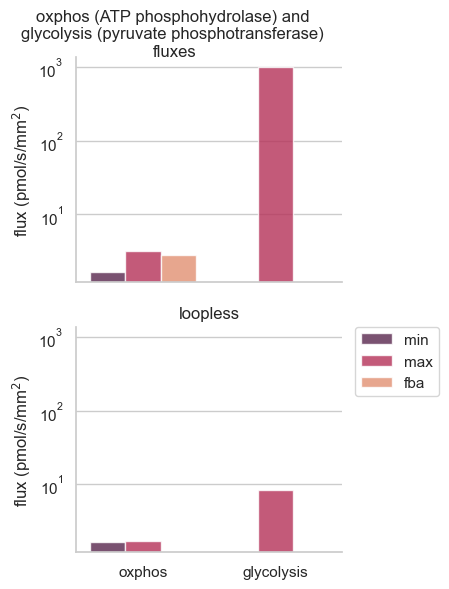

In [228]:
# catplot oxphos_glycolysis_fva_fba_long
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# change order of bars in plot to Human1, Human1 (old), RPE, cone, rod make sure to have seperate bars for each datapoint
g = sns.catplot(
    data=oxphos_glycolysis_fva_fba_long, kind='bar', row='loopless', dodge=True,
    x="index", y="value", hue="type", hue_order=['min','max','fba'],
    order = ['MAR06916_PR','MAR04358_PR'],
        palette="rocket", alpha=.8, height=3,
)
g.despine(left=False)
g.set_axis_labels("","flux (pmol/s/mm$^{2}$)")
g.legend.set_title("")
# rotate x-axis labels
plt.tight_layout()
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
#log scale
plt.yscale('log')
#remove one legend
g._legend.remove()
# change tick axis names
g.set_xticklabels(['oxphos','glycolysis'])
# change subplot titles
g.set_titles(row_template = '{row_name}')
# title of all subplots
g.fig.subplots_adjust(top=0.90)
plt.suptitle('oxphos (ATP phosphohydrolase) and \nglycolysis (pyruvate phosphotransferase) \nfluxes', fontsize=12)



In [ ]:
oxphos_glycolysis_samples.T.to_clipboard()
#melt to long format
oxphos_glycolysis_samples_long = pd.melt(oxphos_glycolysis_samples.reset_index(),\
            id_vars=['index'], \
            value_vars=[0,1,2,3,4,5,6,7,8,9])
oxphos_glycolysis_samples_long  


,index,variable,value
0,MAR06916_PR,0,2.164382
1,MAR04358_PR,0,976.298501
2,MAR06916_PR,1,2.163735
3,MAR04358_PR,1,976.054682
4,MAR06916_PR,2,2.163625
5,MAR04358_PR,2,976.254276
6,MAR06916_PR,3,1.874698
7,MAR04358_PR,3,597.393986
8,MAR06916_PR,4,2.244510
9,MAR04358_PR,4,451.939082


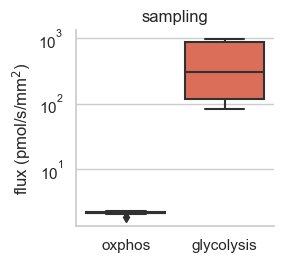

In [229]:
# boxplot oxphos_glycolysis_samples_long as catplot
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

g = sns.catplot(
    data=oxphos_glycolysis_samples_long, kind='box', 
    x="index", y="value",
    order = ['MAR06916_PR','MAR04358_PR'],
        palette="rocket", height=3,
)   
# y log scale
plt.yscale('log')
title = 'oxphos and glycolysis fluxes'
plt.title(title)
# change tick axis names
g.set_xticklabels(['glycolysis','oxphos'])
# plot title
plt.title('sampling')
# y-axis label
plt.ylabel('flux (pmol/s/mm$^{2}$)')
# set figure height and width
plt.tight_layout()
# change x tick labels
g.set_xticklabels(['oxphos','glycolysis'])
# remove x title    
g.set_xlabels('')

In [ ]:
# get model from list with particular id
def get_mod_by_id(item_list, id):
    for item in item_list:
        if item.id == id:
            return item
m = get_mod_by_id(model_list, 'Human-GEM_28062023')
m

Name,Human-GEM_28062023
Memory address,2e93a467400
Number of metabolites,8499
Number of reactions,13085
Number of genes,2897
Number of groups,149
Objective expression,1.0*MAR03964 - 1.0*MAR03964_reverse_c9df9
Compartments,"Cytosol, Extracellular, Lysosome, Endoplasmic reticulum, Mitochondria, Peroxisome, Golgi apparatus, Nucleus, Inner mitochondria"


In [ ]:
def fba_analysis(mod, boundary_dicts, boundary_labels=dict(),results_name=''):    
    # inputs: model, list of boundary dicts {rxnID:(lb,ub)}, objective function rxnID (string)
    import pandas as pd
    from datetime import datetime
    from src.get_info import make_rxn_df, make_compact_rxn_df
    from datetime import datetime

    #  create empty dicts
    bounds = dict() # changed model bounds
    conditions = dict()
    ovs = dict() # objective values
    f = dict() # fba fluxes
    uptake = dict() # uptake fluxes
    secretion = dict() # secretion fluxes
        
    #   set counter, i, to 1
    i = 0
        
    with mod as m:
            
        # run analysis for every dict in list
        for d in boundary_dicts:
            for k in d:   # set bounds for all keys (rxnIDs in dict)
                m.reactions.get_by_id(k).bounds = d[k] # set bounds defined in dict

            # run analysis
            fba = m.optimize() # fba
            
            # objective values
            ovs[i] = [m.objective, m.objective.direction, fba.objective_value]
            
            if fba.status == 'optimal':

                # write analysis info / results into dicts

                # uptake / secretion
                uptake_summary = m.summary().uptake_flux
                secretion_summary = m.summary().secretion_flux
                uptake[i] = pd.DataFrame(uptake_summary['flux'])
                secretion[i] = pd.DataFrame(secretion_summary['flux'])
                
                # all fluxes
                f[i] = fba.to_frame()['fluxes']
          
            # update counter
            i=i+1
    
    # prepare dfs for excel sheet
    model_info = pd.DataFrame([m.id, m.name,m.compartments,m.annotation],\
             index=['id','name','compartments','annotation'],columns = ['model'])
    
    rxn_df = make_rxn_df(m)   
    compact_rxn_df = make_compact_rxn_df(m)  
    
    met_df = pd.DataFrame([[mi.name,mi.compartment,mi.formula,mi.charge,[r.id for r in list(mi.reactions)]] for mi in m.metabolites],\
             index=[m.id for m in m.metabolites],columns=['name','compartment','formula','charge','reactions'])
    
    ovs_df  = pd.concat([pd.DataFrame(boundary_dicts),\
                         pd.DataFrame(boundary_labels),\
                          pd.DataFrame(ovs, index=['objective','objective_direction','objective_value']).T],axis=1)
    
    # uptake / secretion dfs

    uptake_df = pd.concat(uptake,axis=1)
    secretion_df = pd.concat(secretion,axis=1)
    
    secretion_mets = pd.DataFrame([[met.name for met in m.reactions.get_by_id(mets).reactants] \
                                for mets in secretion_df.index],\
                               columns=['metabolite'],index= secretion_df.index)
    uptake_mets = pd.DataFrame([[met.name for met in m.reactions.get_by_id(mets).reactants] \
                                for mets in uptake_df.index],\
                               columns=['metabolite'],index= uptake_df.index)
    
    uptake_df = pd.merge(secretion_mets, uptake_df, left_index=True, right_index=True)  
    secretion_df = pd.merge(secretion_mets, secretion_df, left_index=True, right_index=True)  
                                     
    # sort uptake / secretion dfs
    uptake_df = uptake_df.reindex(uptake_df.fillna(0).sort_values(by=[c for c in secretion_df.columns if 'flux' in c],ascending=False).index)
    secretion_df = secretion_df.reindex(secretion_df.fillna(0).sort_values(by=[c for c in secretion_df.columns if 'flux' in c],ascending=True).index)
    
    # fluxes df
    fluxes_df = pd.concat([pd.DataFrame(f)],keys=["flux"],axis=1)
    fluxes_df = fluxes_df =pd.merge(compact_rxn_df, fluxes_df,left_index=True, right_index=True)
    # sort table on absolute flux size 
    fluxes_df= fluxes_df.reindex(fluxes_df[[c for c in fluxes_df.columns if 'flux' in c]].abs().sort_values(by=[c for c in fluxes_df.columns if 'flux' in c],ascending=False).index)
    fluxes_df[fluxes_df.index.isin([r.id for r in m.reactions if len(r.products)>0])]
    # select internal fluces only
    fluxes_df[fluxes_df.index.isin([r.id for r in m.reactions if len(r.products)>0])]
        
    # date stamp
    datestr = datetime.strftime(datetime.now(), '%H%M_%d-%m-%Y')   
    
    # write excel file
    with pd.ExcelWriter('fba_analysis_' + results_name + '_' + datestr + '.xlsx') as writer:  
        model_info.to_excel(writer, sheet_name = 'model')
        rxn_df.to_excel(writer, sheet_name = 'reactions')
        met_df.to_excel(writer, sheet_name = 'metabolites')
        ovs_df.to_excel(writer, sheet_name = 'objective_values')  
        uptake_df.to_excel(writer, sheet_name = 'uptake')    
        secretion_df.to_excel(writer, sheet_name = 'secretion')    
        fluxes_df.to_excel(writer, sheet_name = 'fluxes')     
        
    return [ovs_df, uptake_df, secretion_df, fluxes_df]

In [ ]:
# set objective function (ATP hydrolysis in PR for combined models)

for m in model_list:
    if 'MAR03964_PR' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_PR'
    elif 'MAR03964_RPE' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964_RPE'
    elif 'MAR03964' in [r.id for r in m.reactions]:
        m.objective = 'MAR03964'
    else:
        print('no ATP hydrolysis reaction (MAR03964) in model: ' + m.id)
